# Automatic classification 2

In this notebook, we focus on finding the local maximum/minimum of the passage matrix and the magnitude of the vector matrix,
which lays the fundation of finding the stable fixed points.

In [178]:
include("simu_utils.jl")
pyplot()    # switch plot backend

Plots.PyPlotBackend()

In [166]:
"""
Get the averaged vector field
"""
function vector_field(sol, stress_t, dt)
    t_vec, σ_vec, A_vec = interpret_sol(sol)
    dσdt = zeros((maximum(σ_vec) + 1, maximum(A_vec) + 1))
    dAdt = zeros((maximum(σ_vec) + 1, maximum(A_vec) + 1))
    passage = zeros((maximum(σ_vec) + 1, maximum(A_vec) + 1))
    
    for i = 2:(length(t_vec) - 1)
        if t_vec[i] >= stress_t
            dσ = σ_vec[i + 1] - σ_vec[i - 1]
            dA = A_vec[i + 1] - A_vec[i - 1]
            # states start from 0 but the index of the array starts from 1
            dσdt[σ_vec[i] + 1, A_vec[i] + 1] += dσ/(2*dt)
            dAdt[σ_vec[i] + 1, A_vec[i] + 1] += dA/(2*dt)
            passage[σ_vec[i] + 1, A_vec[i] + 1] += 1
        end
    end
    
    # avoid divide 0 error
    pos_passage = deepcopy(passage)
    pos_passage[pos_passage .== 0] .= 1
    
    # normalize
    dσdt ./= pos_passage
    dAdt ./= pos_passage
    
    magnitude = sqrt.(dσdt.^2 .+ dAdt.^2)
    return dσdt, dAdt, magnitude, passage
end


vector_field

In [270]:
"""
Vector field plot with quiver
please specify an interval or the plotting is extremely slow
and the vectors are clustered
"""
function plot_vf(dσdt, dAdt; scale = 1.0, interval = 5)
    σ_size = size(dσdt, 1)
    A_size = size(dσdt, 2)
    # make the matrix sparse
    dσdt = dσdt[1:interval:σ_size, 1:interval:A_size]
    dAdt = dAdt[1:interval:σ_size, 1:interval:A_size]
    # plot
    σ_grid = ((1:interval:σ_size) .- 1) * ones(1, Int64(ceil(A_size/interval)) )
    A_grid = ones(Int64(ceil(σ_size/interval)), 1) * ((1:interval:A_size) .- 1)'
    quiver(σ_grid[:], A_grid[:], quiver = (scale .* dσdt[:], scale .* dAdt[:]), 
        alpha = 0.5, color = "blue")
end

plot_vf

## Find the stable fixed points

In [379]:
"""
find the fixed points
by the criterion: local minimum of vector magnitude
and local maximum of trajectory density
"""
function find_fp(sol, stress_t, dt; smooth_size = 7, neighbor_size = 3)
    # generate (magnitude of) vf, traj density
    dσdt, dAdt, magnitude, passage = vector_field(sol, stress_t, dt)
    
    # smooth
    ms = naive_smooth_2d(magnitude, smooth_size)
    ps = naive_smooth_2d(passage, smooth_size)

    # find local min/max
    v_min = local_min_2d(ms, neighbor_size)
    d_min = local_min_2d(-ps, neighbor_size)
    
    # find intersect with tolerance
    # also the density has to be large enough, and vf small
    n_fp = 0
    fp = zeros(size(d_min))    # initialize
    # max distance between density max & mag. min
    dist_tol = 2 * neighbor_size + 1
    # absolute value threshold
    thres_v = 1e-1
    thres_d = 1e-2
    for i = 1:size(d_min, 1)
        if ms[d_min[i, :]...] > maximum(ms)*thres_v ||
            ps[d_min[i, :]...] < maximum(ps)*thres_d
            continue
        end
        for j = 1:size(v_min, 1)
            dist = sqrt(sum((v_min[j, :] .- d_min[i, :]).^2))
            if dist < dist_tol
                n_fp += 1
                fp[n_fp, :] .= d_min[i, :]
                break
            end
        end
    end
    
    fp = fp[1:n_fp, :]
    fp .-= 1    # convert index to # moleclues
    return fp
end

"""
marking the fixed points on the vector field
"""
function plot_vf_w_fp(dσdt, dAdt, fp; scale = 1.0, interval = 5)
    plt = plot_vf(dσdt, dAdt, scale = scale, interval = interval)

    scatter!(plt, fp[:, 1], fp[:, 2], color = :green, markersize = 10, 
        markerstrokewidth = 0, label = "fixed points", legend = :topright)
end

plot_vf_w_fp

In [255]:
function naive_smooth_2d(mat, smooth_size = 5)
    new_mat = zeros(size(mat))
    half_smooth_size = Int64(floor(smooth_size/2))
    for i = 1:size(mat, 1)
        for j = 1:size(mat, 2)
            x_end = min(i + half_smooth_size, size(mat, 1))
            x_start = max(i + 1 - (smooth_size - half_smooth_size), 1)
            y_end = min(j + half_smooth_size, size(mat, 2))
            y_start = max(j + 1 - (smooth_size - half_smooth_size), 1)
            new_mat[i, j] = mean(mat[x_start:x_end, y_start:y_end])
        end
    end
    return new_mat
end

naive_smooth_2d (generic function with 2 methods)

In [304]:
"""
find local minimum
the result is given by a col of x and a col of y
"""
function local_min_2d(mat, neighbor_size = 1)
    δ = 1e-6    # threshold for minimum
    n_min = 0
    x_idx = zeros(Int64, length(mat[:]))
    y_idx = zeros(Int64, length(mat[:]))
    for i = 1:size(mat)[1]
        for j = 1:size(mat)[2]
            x_start = max(1, i - neighbor_size)
            x_end = min(size(mat)[1], i + neighbor_size)
            y_start = max(1, j - neighbor_size)
            y_end = min(size(mat)[2], j + neighbor_size)
            sorted = sort(mat[x_start:x_end, y_start:y_end][:])
            # strictly greater than
            if sorted[1] == mat[i, j] && sorted[2] - mat[i, j] > δ * abs(mat[i, j])
                n_min += 1
                x_idx[n_min] = i
                y_idx[n_min] = j
            end
        end
    end
    x_idx = x_idx[1:n_min]    # truncate
    y_idx = y_idx[1:n_min]
    return [x_idx y_idx]
end

local_min_2d

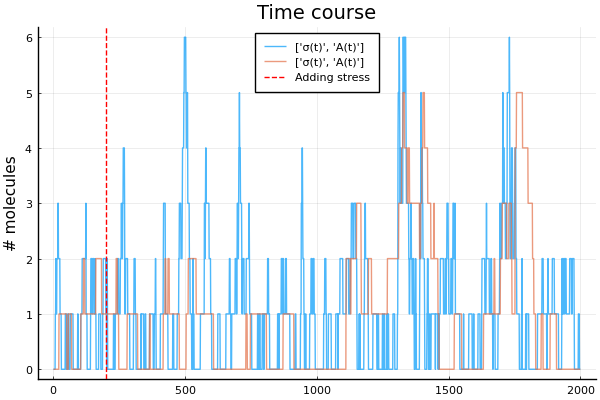

KD/KS = 0.01; KS = 20.0; τ₂/τ₁ = 5.0; β= 100.0; n = 3.0

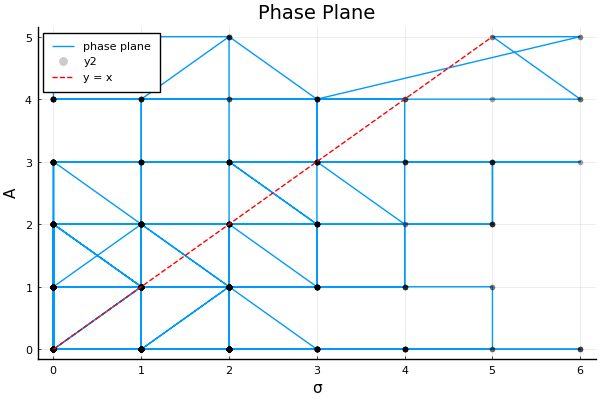

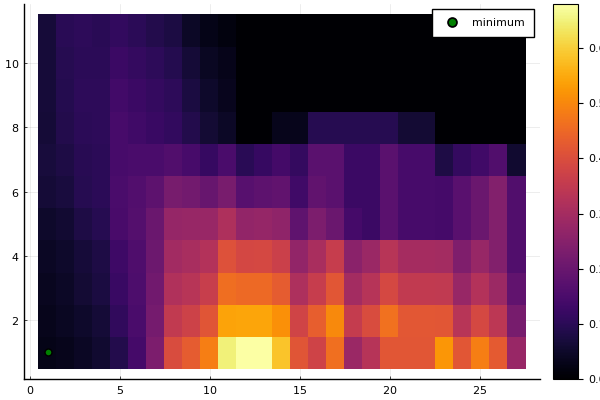

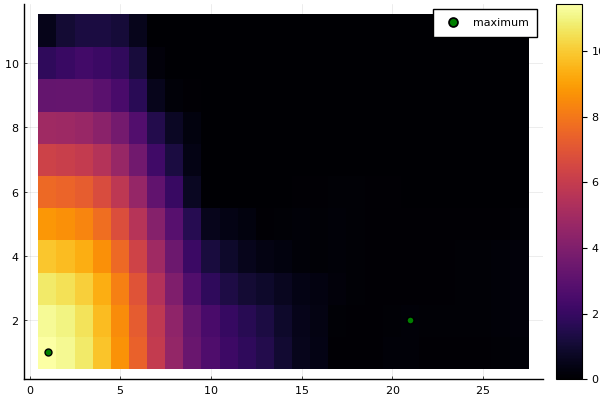


after smoothing

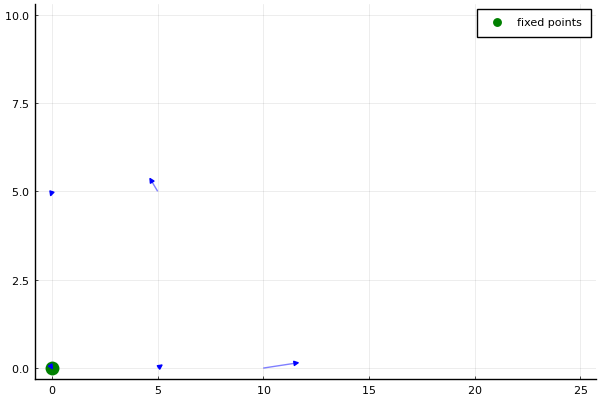

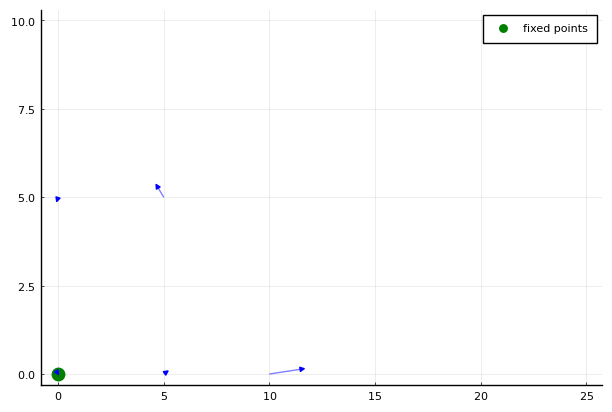


[0.0 0.0]


In [397]:
timescale = 10
timecourse = 1e6
smooth_size = 7

sigma_model = reaction_system()

# stochastic pulsing
# sol = simu_all(sigma_model, _KS = 15.0, _rK = 0.5, _β = 100.0, _τ₁ = timescale, _rτ = 5.0, _n = 3.0, 
#     show_hill = false, max_t = timecourse)

#oscillation
sol = simu_all(sigma_model, _KS = .5, _rK = 1.0, _β = 100.0, _τ₁ = timescale, _rτ = 5.0, _n = 3.0, 
    show_hill = false, max_t = timecourse)

# stochastic switching
# sol = simu_all(sigma_model, _KS = 15.0, _rK = 1.6, _β = 100.0, _τ₁ = timescale, _rτ = 5.0, _n = 3.0, 
#     show_hill = false, max_t = timecourse)

# stochastic anti-pulsing
# sol = simu_all(sigma_model, _KS = 1.0, _rK = 1.6, _β = 100.0, _τ₁ = timescale, _rτ = 5.0, _n = 3.0, 
#     show_hill = false, max_t = timecourse)

# homo activation
# sol = simu_all(sigma_model, _KS = 1.0, _rK = 2.6, _β = 100.0, _τ₁ = timescale, _rτ = 5.0, _n = 3.0, 
#     show_hill = false, max_t = timecourse)

# het activation
# sol = simu_all(sigma_model, _KS = 15.0, _rK = 2.6, _β = 100.0, _τ₁ = timescale, _rτ = 5.0, _n = 3.0, 
#     show_hill = false, max_t = timecourse)

dσdt, dAdt, magnitude, passage = vector_field(sol, 200.0, 1.0)
plot_vf(dσdt, dAdt)    # plot

# smoothing
ms = naive_smooth_2d(magnitude, smooth_size)
ps = naive_smooth_2d(passage, 4)

println("after smoothing")
pm = heatmap(1:size(magnitude, 1), 1:size(magnitude, 2), ms')
pp = heatmap(1:size(magnitude, 1), 1:size(magnitude, 2), log.(ps' .+ 1))
v_min = local_min_2d(ms, 3)
d_min = local_min_2d(-ps, 3)
display(scatter!(pm, v_min[:, 1], v_min[:, 2], color = :green, labels = "minimum", markersize = 5));
display(scatter!(pp, d_min[:, 1], d_min[:, 2], color = :green, labels = "maximum", markersize = 5));
# println("vector field min")
# display(v_min)
# println("density max")
# display(d_min)

# plot fixed points on vf
fp = find_fp(sol, 200.0, 1.0)
println(fp)
display(plot_vf_w_fp(dσdt, dAdt, fp, scale = 2.0))

## Experiment on divergence

The fixed points may have specific signatures in terms of divergence.
However, we find that the local maximum of divergence is not the fixed point, but 
the point where the trajectory accelerates, e.g., 
for oscillations, not at the trough but at somewhere just above the trough, where the
trajectory accelerates to the crest.

Thus, divergence is not involved in the detection of FP (eventually)

In [196]:
function divergence_2d(x, y, vf_x, vf_y)
    if length(x) != size(vf_x, 1) || length(y) != size(vf_x, 2) || size(vf_x) != size(vf_y)
        println("Error: in divergence the size of the vector field" *
            "does not match the size of x or y. Abort")
        return nothing
    end
    
    divergence = zeros(size(vf_x))    # initialize
    for i = 1:length(x)
        for j = 1:length(y)
            if i == 1
                dx = x[i + 1] - x[i]
                dvx = vf_x[i + 1, j] - vf_x[i, j]
            elseif i == length(x)
                dx = x[i] - x[i - 1]
                dvx = vf_x[i, j] - vf_x[i - 1, j]
            else
                dx = x[i + 1] - x[i - 1]
                dvx = vf_x[i + 1, j] - vf_x[i - 1, j]
            end
            div_x = dvx / dx
            
            if j == 1
                dy = y[j + 1] - y[j]
                dvy = vf_y[i, j + 1] - vf_y[i, j]
            elseif j == length(y)
                dy = y[j] - y[j - 1]
                dvy = vf_y[i, j] - vf_y[i, j - 1]
            else
                dy = y[j + 1] - y[j - 1]
                dvy = vf_y[i, j + 1] - vf_y[i, j - 1]
            end
            div_y = dvy / dy
            
            divergence[i, j] = div_x + div_y
        end
    end
    
    return divergence
end

divergence_2d (generic function with 2 methods)

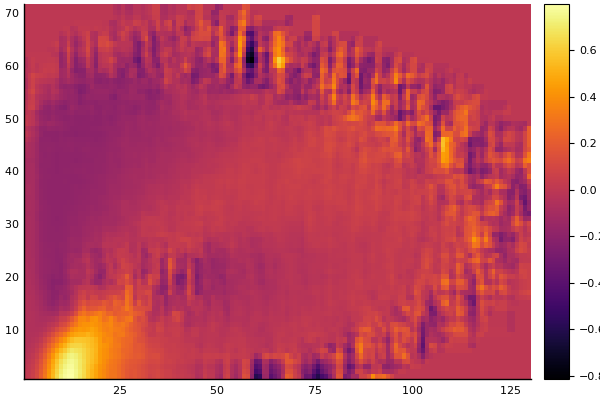

In [207]:
dσdt_smooth = naive_smooth_2d(dσdt, smooth_size)
dAdt_smooth = naive_smooth_2d(dAdt, smooth_size)

div = divergence_2d(0:(size(dσdt_smooth, 1) - 1), 0:(size(dσdt_smooth, 2) - 1), 
    dσdt_smooth, dAdt_smooth)
heatmap(1:size(div, 1), 1:size(div, 2), div')